In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x +5

In [3]:
f(3.0)

20.0

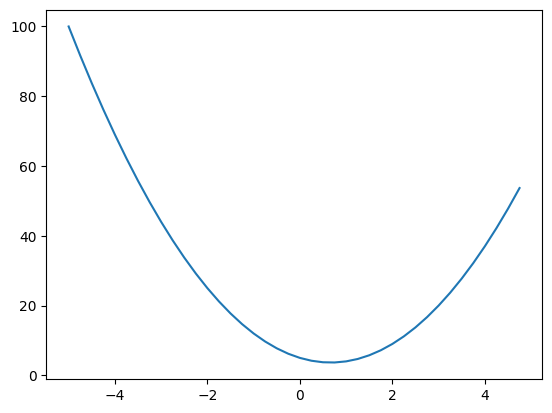

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
class Value:
    def __init__(self, data,_children=(),_op='',label=None):
        self.data = data
        self._prev=set(_children)
        self._op=_op
        self.label=label
        
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        #实现Value可以直接与其他类型值的加法
        other=other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self, other),"+")
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        #与add方法类似
        other=other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self, other),"*")
        
        def _backward():
            self.grad += other.data * out.grad ## 符号为+=才是正确的，若仅是=，则会覆盖，如b=a+a,则b.grad=2*a.grad，若为=则b.grad=a.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        out = Value(self.data ** other,(self,),f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self/other
        return self * other ** -1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,), "tanh")
        
        def _backward():
            self.grad += (1.0 - out.data ** 2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x=self.data
        out = Value(math.exp(x),(self,), "exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        self.grad = 1.0
        topo = []
        visited =set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(o)
        
        for node in reversed(topo):
            node._backward()
    


In [6]:
a=Value(2.0)
b=Value(3.0)
a-b

Value(data=-1.0)

In [7]:
from graphviz import Digraph
import os
os.environ["PATH"] += os.pathsep + 'C:\\Users\\15963\\Desktop\\micrograd\\windows_10_cmake_Release_Graphviz-12.2.1-win64\\Graphviz-12.2.1-win64\\bin\\'
   
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    #assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid= str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f |grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [8]:
x1 = Value(2.0,label='x1')
w1 = Value(-3.0,label='w1')
x2 = Value(0.0,label='x2')
w2 = Value(1.0,label='w2')

b=Value(6.8813735878195432,label='b')

x1w1 = x1 * w1;x1w1.label='x1*w1'
x2w2 = x2 * w2;x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label='x1*w1 + x2*w2'
n=x1w1x2w2 + b;n.label='n'
o=n.tanh();o.label='o'

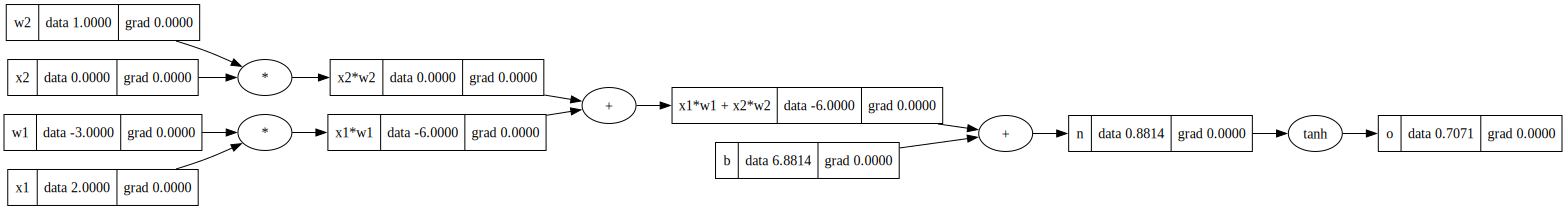

In [9]:
draw_dot(o)

In [10]:
import torch
import random

In [11]:
x1 = torch.tensor([2.0]).double()              ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()              ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()             ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()              ; w2.requires_grad = True
b = torch.tensor([6.8813735878195432]).double(); b.requires_grad = True
n=x1*w1+x2*w2+b
o=torch.tanh(n)

print(o.data.item())
o.backward()

print('--------')
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

0.7071066904050358
--------
-1.5000003851533106
1.0000002567688737
0.5000001283844369
0.0


In [21]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = [Value(random.uniform(-1,1))]
        
    def __call__(self,x):
        act = sum([wi*xi for wi,xi in zip(self.w,x)],Value(0)) #与视频不同，视频中是sum([wi*xi for wi,xi in zip(self.w,x)],self.b)但未修改之前会报错typeerror
        act = self.b[0] + act #与视频不同
        out = act.tanh()
        return out
    
    def parameters(self): #方便对参数进行更新
        return self.w + [self.b]

    
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        # 返回所有神经元的参数
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        
        #return [p for n in self.neurons for p in n.parameters()]

class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [Value(1.0),Value(2.0),Value(3.0)] #输入层 与视频不同使用value
n = MLP(3,[4,4,1])
#n(x)
len(n.parameters())

41

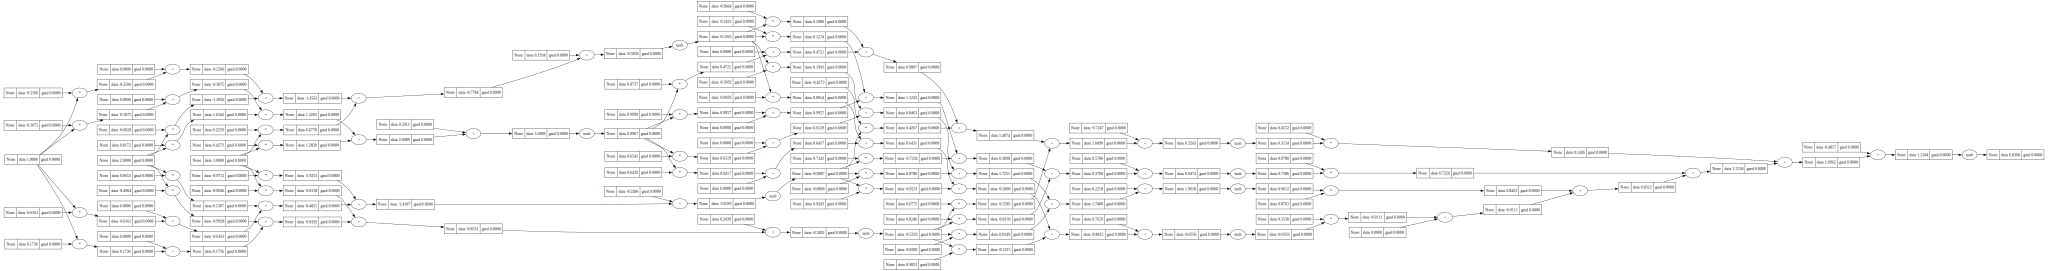

In [13]:
draw_dot(n(x))

In [27]:
xs = [
    [Value(1.0),Value(2.0),Value(3.0)],
    [Value(2.0),Value(3.0),Value(4.0)],
    [Value(3.0),Value(4.0),Value(5.0)],
    [Value(4.0),Value(5.0),Value(6.0)],
    [Value(5.0),Value(6.0),Value(7.0)],
    [Value(6.0),Value(7.0),Value(8.0)],
    [Value(7.0),Value(8.0),Value(9.0)],
    [Value(8.0),Value(9.0),Value(10.0)],
    [Value(9.0),Value(10.0),Value(11.0)],
    [Value(10.0),Value(11.0),Value(12.0)],
]

ys = [Value(3.0),Value(5.0),Value(7.0),Value(9.0),Value(11.0),Value(13.0),Value(15.0),Value(17.0),Value(19.0),Value(21.0)]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.7796803265862099),
 Value(data=-0.7525695196791687),
 Value(data=-0.7674912256980927),
 Value(data=-0.7834556303842997),
 Value(data=-0.7945395001266803),
 Value(data=-0.8011883392410377),
 Value(data=-0.8044038981736631),
 Value(data=-0.8049968109772124),
 Value(data=-0.8035833578016996),
 Value(data=-0.8006756962857264)]

In [28]:
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred)) #loss越大，说明pred（预测值）与y（真实值）差距越大
loss

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [17]:
for p in n.parameters(): #将所有参数的梯度清零，否则会累加，特别容易被忽略
    p.grad = 0.0
loss.backward()

AttributeError: 'Tensor' object has no attribute '_prev'

In [ ]:
for p in n.parameters():
    p.data += -0.01 * p.grad #0.01为学习率,太高即步子过大，可能导致loss反而上升，太小则收敛速度慢